<a href="https://colab.research.google.com/github/cascandaliato/covid19-notebook/blob/master/charts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
DATA_SOURCE = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-andamento-nazionale.json'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as trn
import pandas as pd
%matplotlib inline

In [3]:
dataset = pd.read_json(DATA_SOURCE)
# print(dataset.columns)

# format and sort by date
dataset['data'] = dataset['data'].transform(lambda s: s[:10])
dataset.sort_values(by=['data'], inplace=True)
dataset['data'] = pd.to_datetime(dataset['data'])
footer = f'Source https://github.com/pcm-dpc/COVID-19 - Last Updated {dataset["data"].tolist()[-1].strftime("%Y-%m-%d")}'
dataset['data'] = dataset['data'].dt.strftime('%d %b')

measures = {
            'deceduti': 'Deaths',
            'terapia_intensiva': 'Intensive Care',
            'dimessi_guariti': 'Recovered',
            'totale_positivi': 'Active Cases'
           }

sub_measures = {
                'delta': { 'color': 'plum', 'label': 'First Derivative', 'is_percentage': False },
                'delta_2': { 'color': 'sandybrown', 'label': 'Second Derivative', 'is_percentage': False },
                'delta_3': { 'color': 'yellowgreen', 'label': 'Third Derivative', 'is_percentage': False }
               }

for measure in measures:
    dataset[f'{measure}_delta'] = dataset[measure].diff()
    dataset[f'{measure}_delta_2'] = dataset[f'{measure}_delta'].diff()
    dataset[f'{measure}_delta_3'] = dataset[f'{measure}_delta_2'].diff()

dataset.drop(columns=['casi_testati', 'note', 'note_test', 'note_casi', 'casi_da_sospetto_diagnostico', 'casi_da_screening', 'ingressi_terapia_intensiva'], inplace=True)
dataset = dataset[['data'] + [f'{m}{suffix}' for m in measures for suffix in ['', '_delta', '_delta_2', '_delta_3']]]
dataset.tail(5)

,data,deceduti,deceduti_delta,deceduti_delta_2,deceduti_delta_3,terapia_intensiva,terapia_intensiva_delta,terapia_intensiva_delta_2,terapia_intensiva_delta_3,dimessi_guariti,dimessi_guariti_delta,dimessi_guariti_delta_2,dimessi_guariti_delta_3,totale_positivi,totale_positivi_delta,totale_positivi_delta_2,totale_positivi_delta_3
924,05 Sep,175872,40.0,10.0,28.0,185,-5.0,-7.0,-16.0,21179545,20274.0,2093.0,13728.0,589460,-13706.0,-8691.0,-15880.0
925,06 Sep,175952,80.0,40.0,30.0,185,0.0,5.0,12.0,21222429,42884.0,22610.0,20517.0,571344,-18116.0,-4410.0,4281.0
926,07 Sep,176009,57.0,-23.0,-63.0,184,-1.0,-1.0,-6.0,21255541,33112.0,-9772.0,-32382.0,555745,-15599.0,2517.0,6927.0
927,08 Sep,176098,89.0,32.0,55.0,185,1.0,2.0,3.0,21313083,57542.0,24430.0,34202.0,515431,-40314.0,-24715.0,-27232.0
928,09 Sep,176157,59.0,-30.0,-62.0,172,-13.0,-14.0,-16.0,21341186,28103.0,-29439.0,-53869.0,502811,-12620.0,27694.0,52409.0


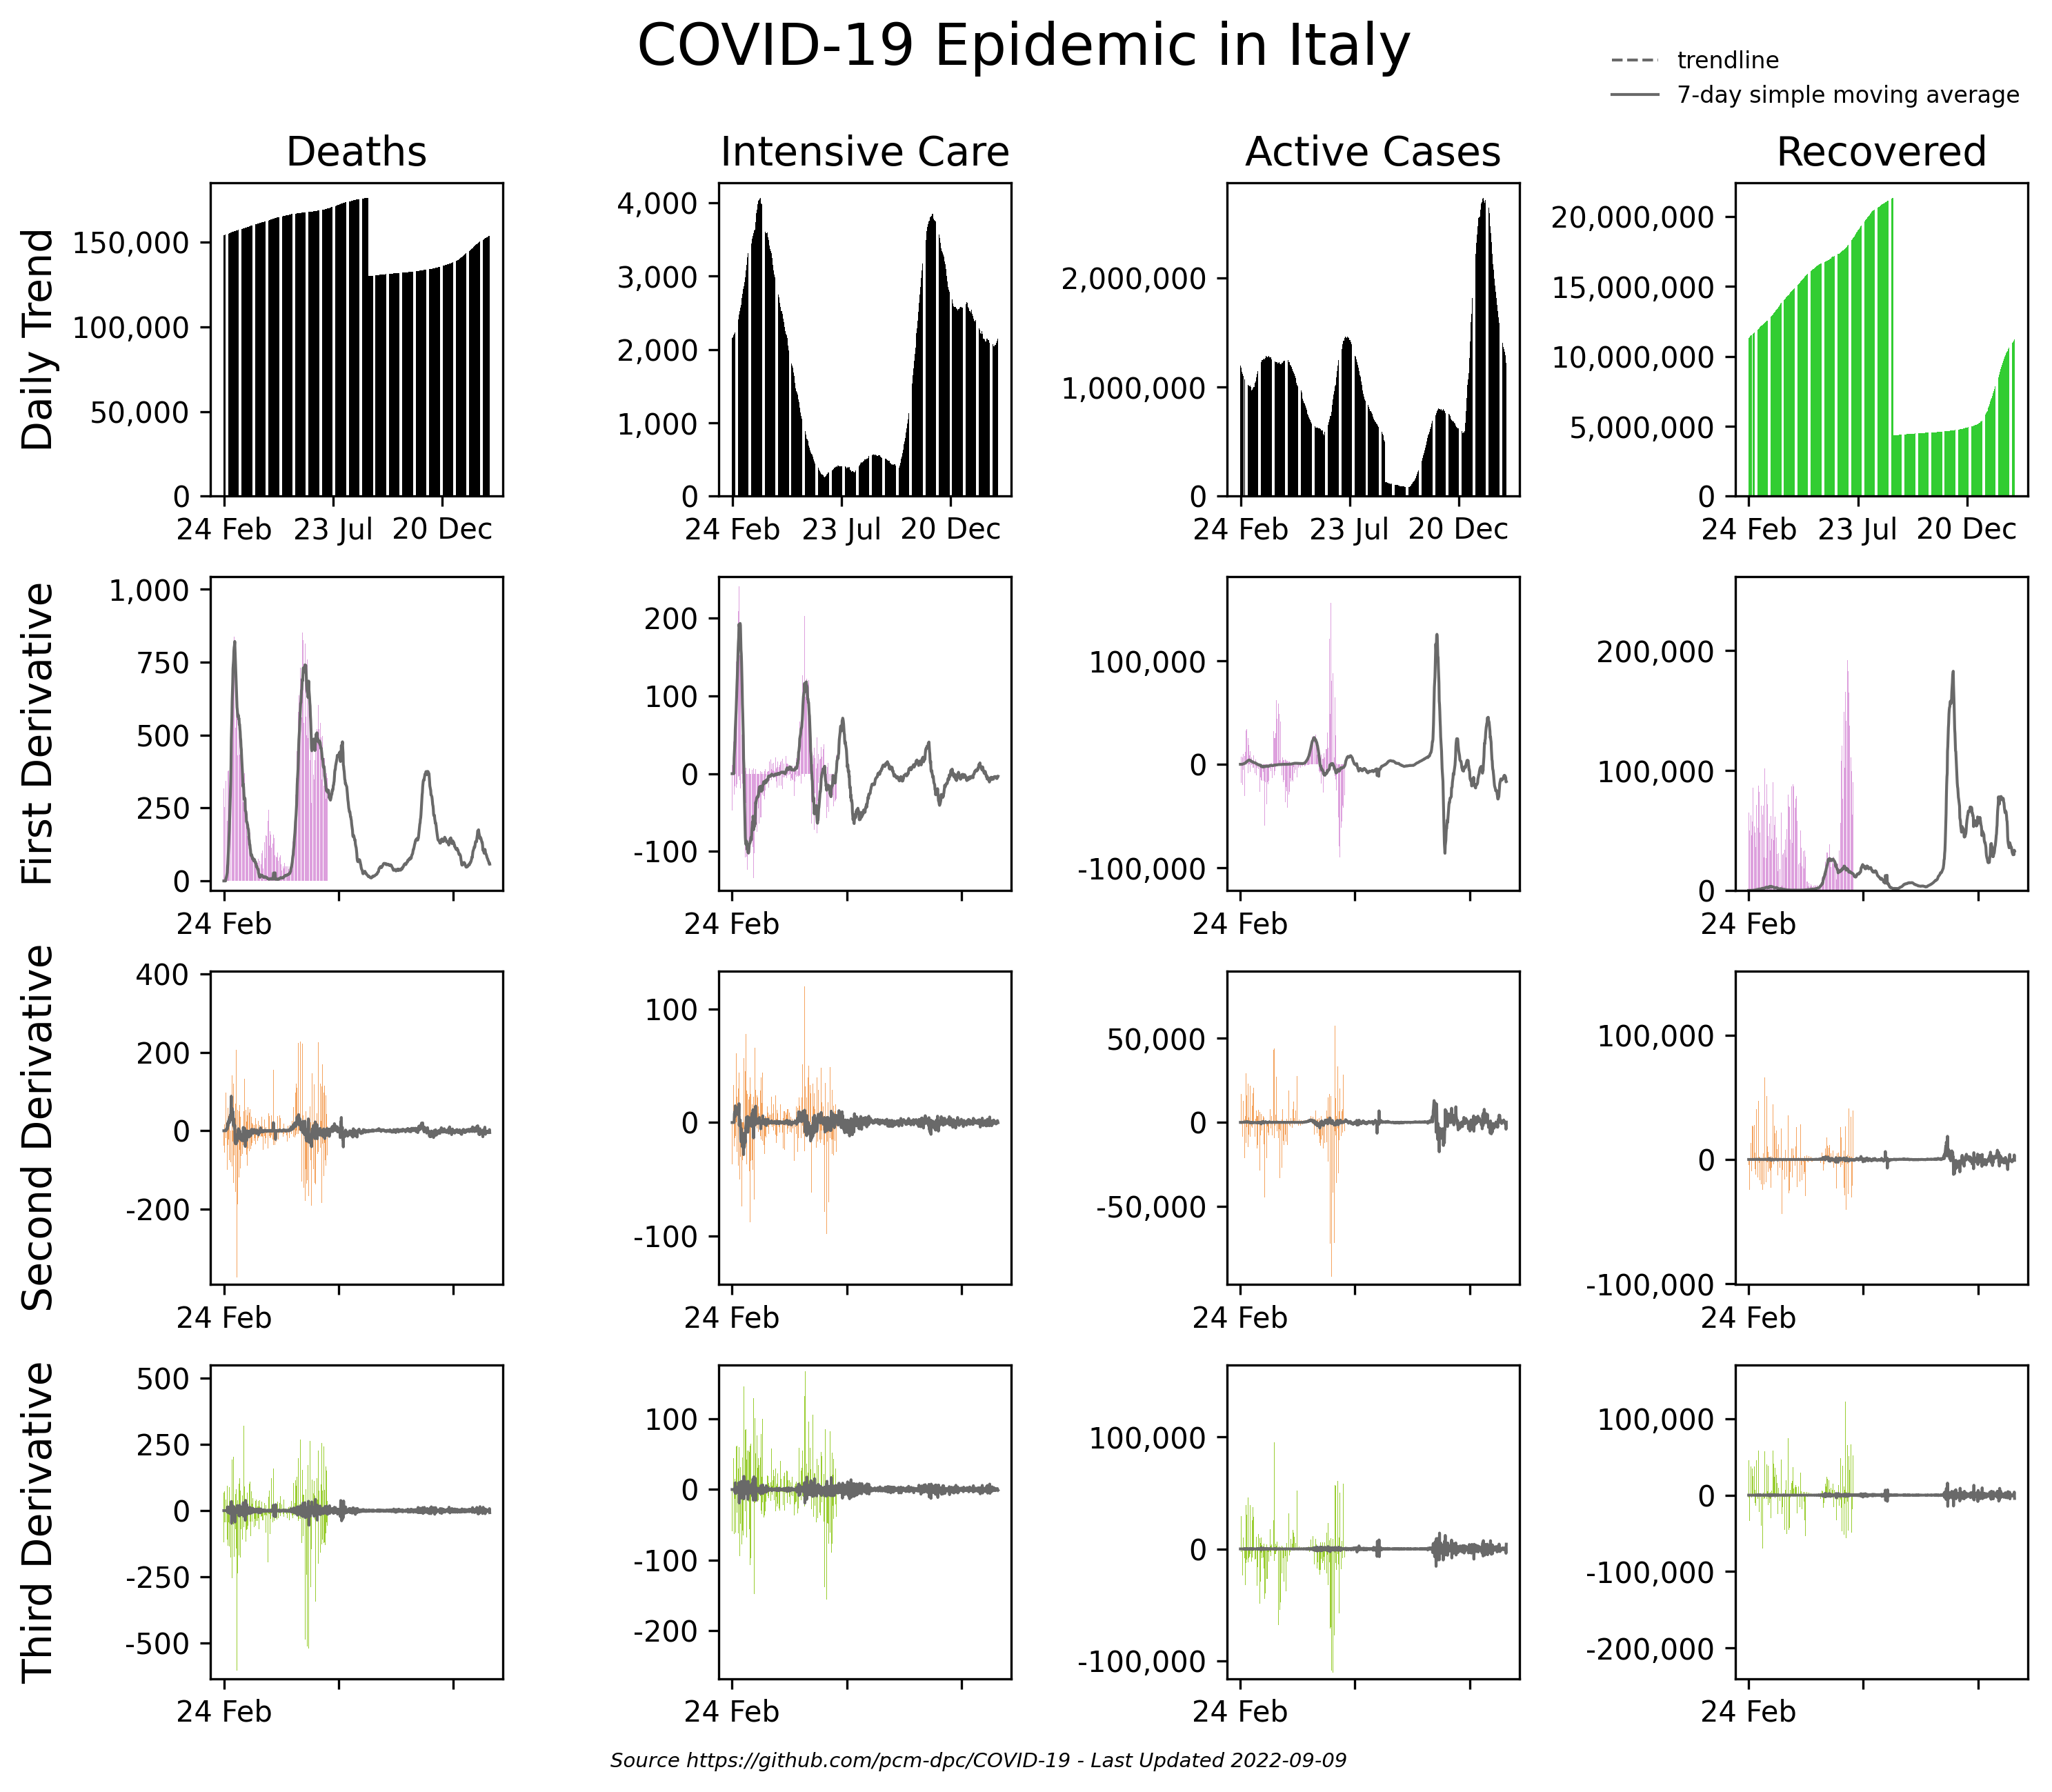

In [4]:
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter

moving_avg_days = 7

legend_lines = [Line2D([0], [0], color='dimgray', lw=1, ls='--'),
                Line2D([0], [0], color='dimgray', lw=1, ls='-')]
legend_labels = ('trendline', f'{moving_avg_days}-day simple moving average')


def plot(ax, measure, display_y_labels=False, main_color='black'):
    x = dataset['data']
    y = dataset[measure]

    ax[0].bar(x, y, color=main_color)
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(3))
    ax[0].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    ax[0].set_title(measures[measure], fontsize=14)
    
    if display_y_labels:
        ax[0].set_ylabel('Daily Trend', fontsize=14)

    for i, sub_measure in enumerate(sub_measures):
        color = sub_measures[sub_measure]['color']
        label = sub_measures[sub_measure]['label']

        if display_y_labels:
            ax[i+1].set_ylabel(label, fontsize=14)

        y_sub = dataset[f'{measure}_{sub_measure}']
        ax[i+1].bar(x, y_sub, color=color, lw=1)

        # trendline
        z = np.polyfit(range(len(x)), y_sub, 1)
        p = np.poly1d(z)
        ax[i+1].plot(range(len(x)), p(range(len(x))), color='dimgray', lw=legend_lines[0].get_linewidth(), ls=legend_lines[0].get_linestyle())
        
        # n-day simple moving average
        rolling = y_sub.rolling(window=moving_avg_days).mean().fillna(value=0)
        ax[i+1].plot(range(len(x)), rolling, color='dimgray', lw=legend_lines[1].get_linewidth(), ls=legend_lines[1].get_linestyle())

        # limit number of x ticks
        ax[i+1].xaxis.set_major_locator(plt.MaxNLocator(3))

        # set range for y axes
        ax[i+1].set_ylim((min(0, y_sub.min()*1.05), y_sub.max()*1.05))
        ax[i+1].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))


fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 8), dpi=300)

plot(axes[:, 0], 'deceduti', True)
plot(axes[:, 1], 'terapia_intensiva')
plot(axes[:, 2], 'totale_positivi')
plot(axes[:, 3], 'dimessi_guariti', False, 'limegreen')

plt.tight_layout()

# legend, title and footer
fig.legend(legend_lines, legend_labels, loc=(0.781, 0.935), fontsize=8, frameon=False)
fig.suptitle('COVID-19 Epidemic in Italy', y=1.05, fontsize=20)
fig.text(0.3, -0.005, footer, fontsize=7, style='italic')
fig.align_ylabels()

plt.savefig('grid.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0.2)
plt.show()

<ipython-input-5-6b49ff4c69e1>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(dates, rotation=45, horizontalalignment='right', fontsize=10)


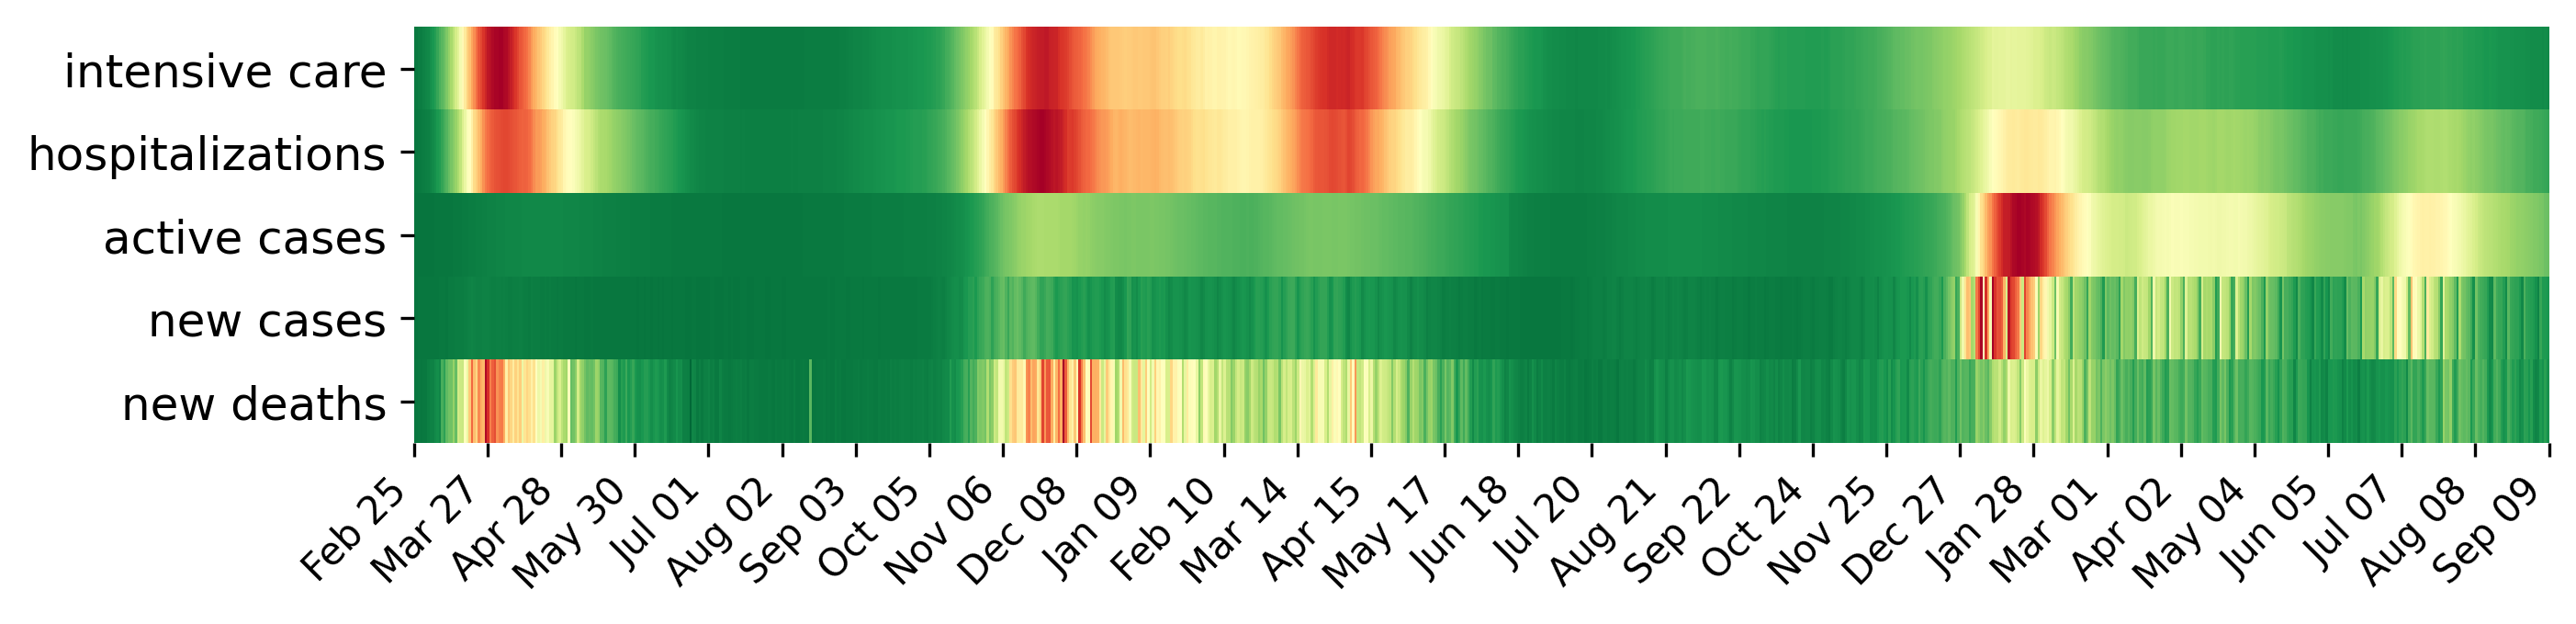

In [5]:
import seaborn as sns

dataset = pd.read_json(DATA_SOURCE, convert_dates=['data'])
dataset = dataset[['data', 'terapia_intensiva', 'totale_ospedalizzati',
                   'totale_positivi', 'nuovi_positivi', 'deceduti']]
dataset.columns = ['date', 'intensive care', 'hospitalizations',
                    'active cases', 'new cases', 'new deaths']

dataset['new deaths'] = dataset['new deaths'].diff()
dataset.dropna(inplace=True)
dataset.set_index('date', inplace=True)
dataset = dataset / dataset.max()

fig, ax = plt.subplots(figsize=(10, 2), dpi=300)

NUM_X_TICKS = 30
g = sns.heatmap(dataset.transpose(), square=False, cbar=False, cmap='RdYlGn_r')
# x
ax.xaxis.set_major_locator(plt.LinearLocator(NUM_X_TICKS))
num_dates = len(dataset)
dates = [dataset.index.strftime('%b %d')[i] for i in  np.linspace(0,num_dates-1,NUM_X_TICKS, dtype=np.dtype(np.int16))]
g.set_xticklabels(dates, rotation=45, horizontalalignment='right', fontsize=10)
ax.set_xlabel('')
# y
g.set_yticklabels(map(lambda s: s.replace('_', ' '), list(dataset.columns)))
g.tick_params(axis="y", labelsize=12)
# save and show
plt.savefig('heatmap.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0.2)
plt.show()

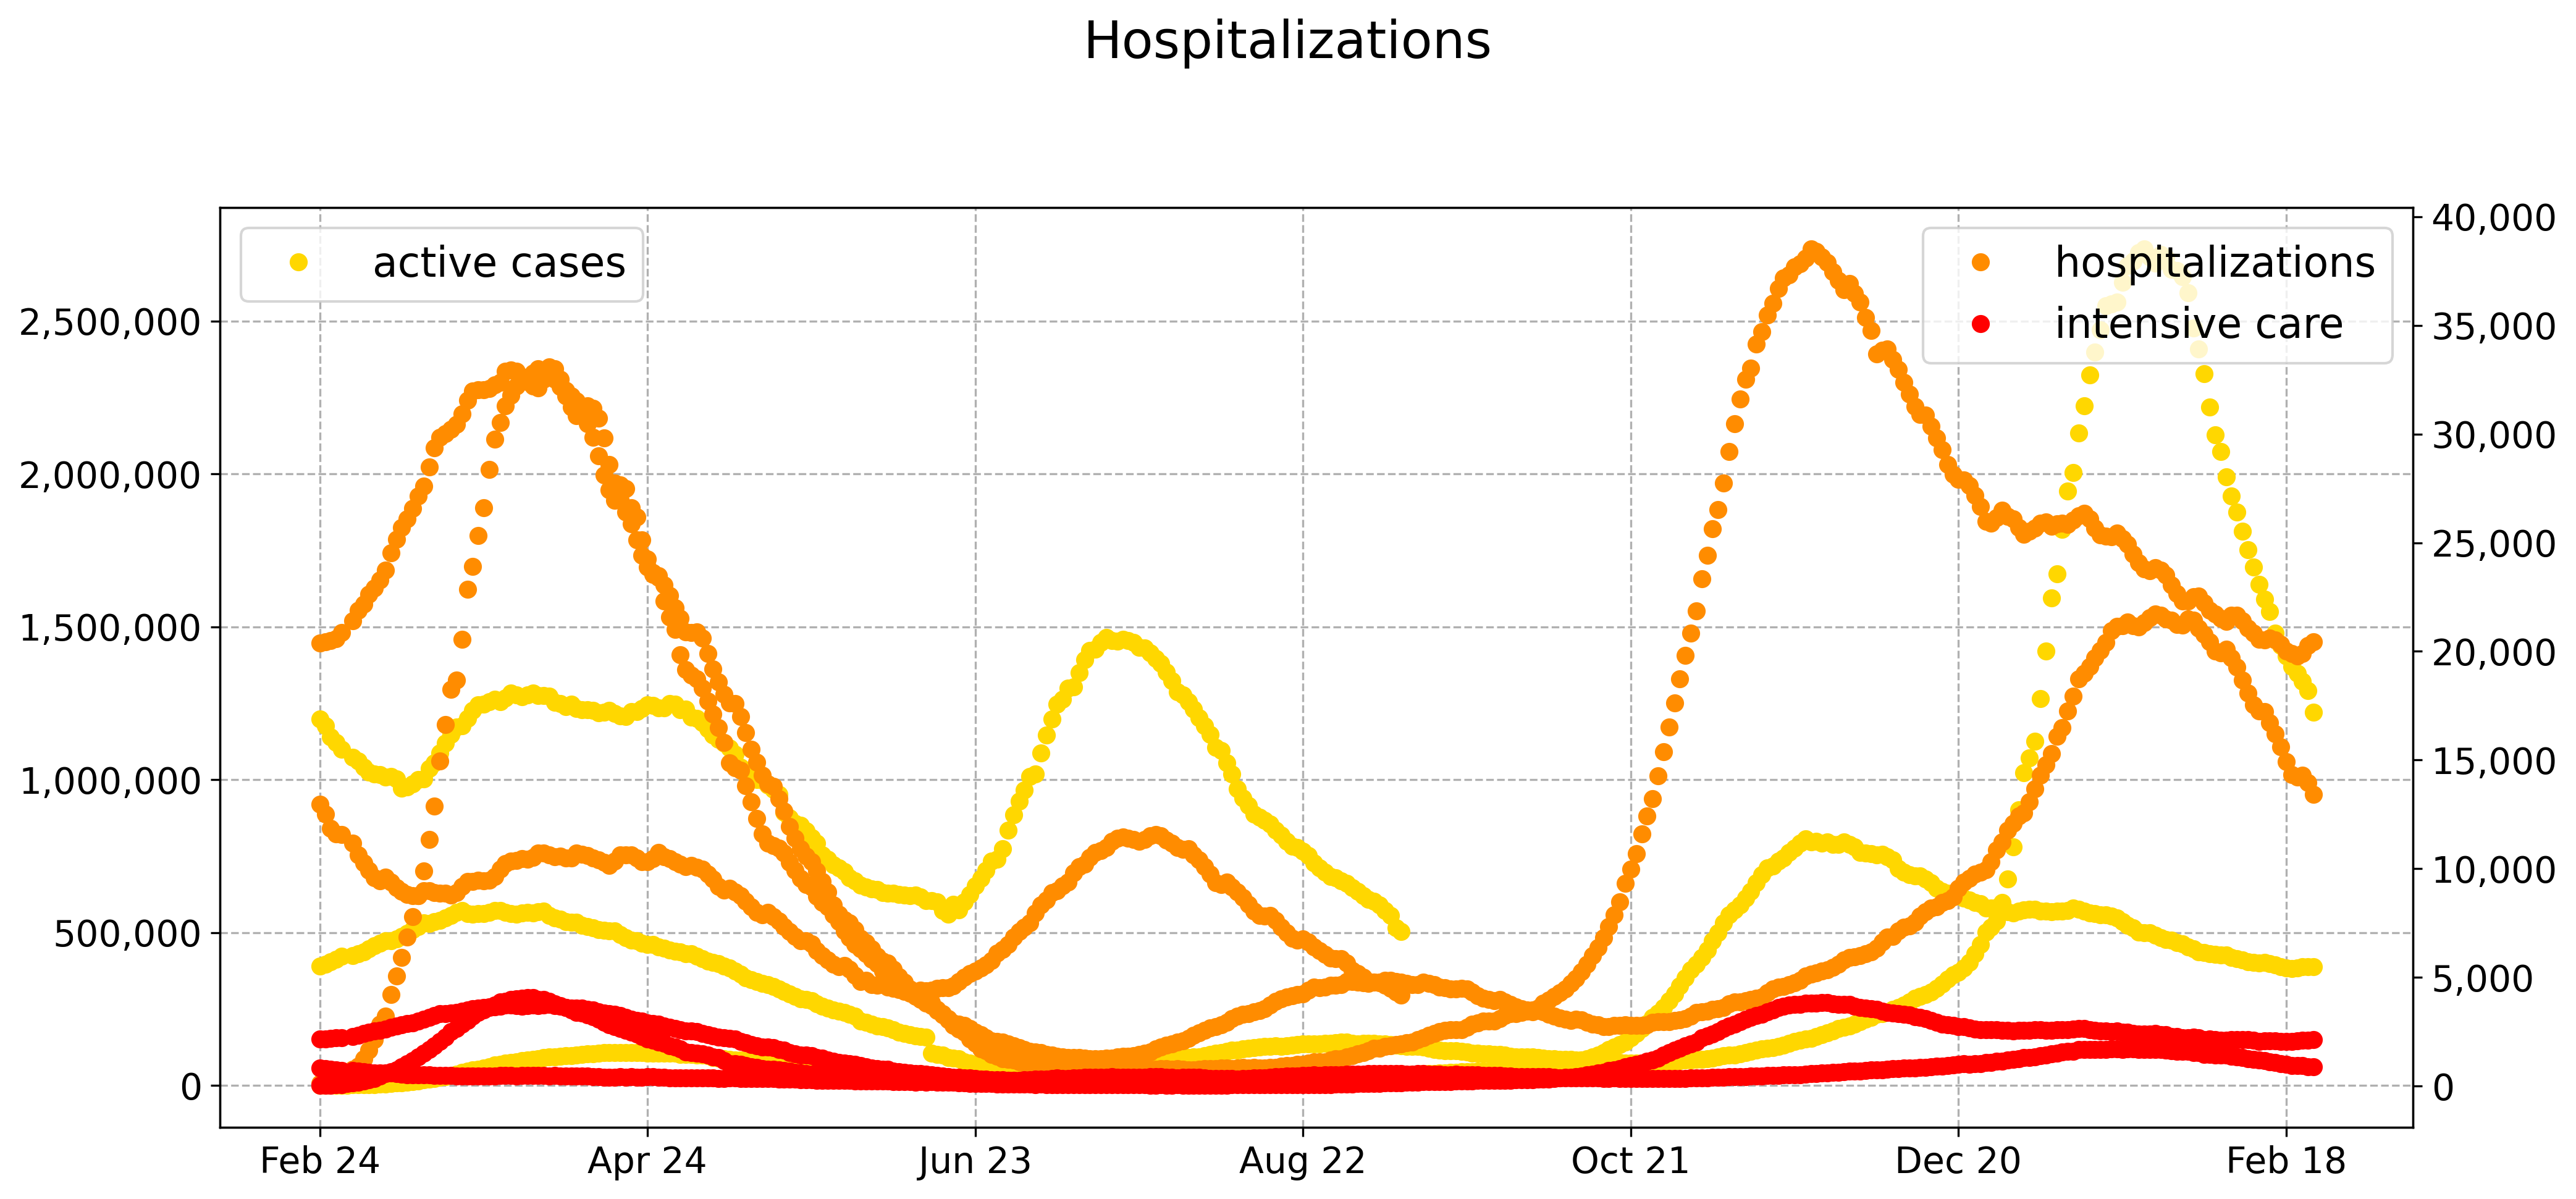

In [6]:
from matplotlib.ticker import FuncFormatter
from datetime import datetime, timedelta


def to_date_labels(arr):
    return list(map(lambda d: d.date().strftime('%b %d'), arr))


def fit_and_plot(axes, column, label, color):
    series = dataset[column]
    x_base = range(len(dates))
    axes.plot(dates,series,'o', label=label, color=color)


dataset = pd.read_json(DATA_SOURCE)
dates = to_date_labels(list(pd.to_datetime(dataset['data'])))

fig, ax1 = plt.subplots(figsize=(14,6), dpi=300)
fit_and_plot(ax1, 'totale_positivi', 'active cases', 'gold')

ax2 = ax1.twinx()
fit_and_plot(ax2, 'totale_ospedalizzati', 'hospitalizations', 'darkorange')
fit_and_plot(ax2, 'terapia_intensiva', 'intensive care', 'red')

# makeup
ax1.legend(loc='upper left', fontsize=16)
ax1.xaxis.set_major_locator(plt.MaxNLocator(8))
ax1.tick_params(axis='x', labelsize=14)
ax1.grid(b=True, which='major', linestyle='--')
ax1.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.tick_params(axis='y', labelsize=14)

ax2.legend(loc='upper right', fontsize=16)
ax2.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.tick_params(axis='y', labelsize=14)

fig.suptitle('Hospitalizations', y=1.07, fontsize=20)
plt.tight_layout()

plt.savefig('hospitalizations.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0.2)

plt.show()

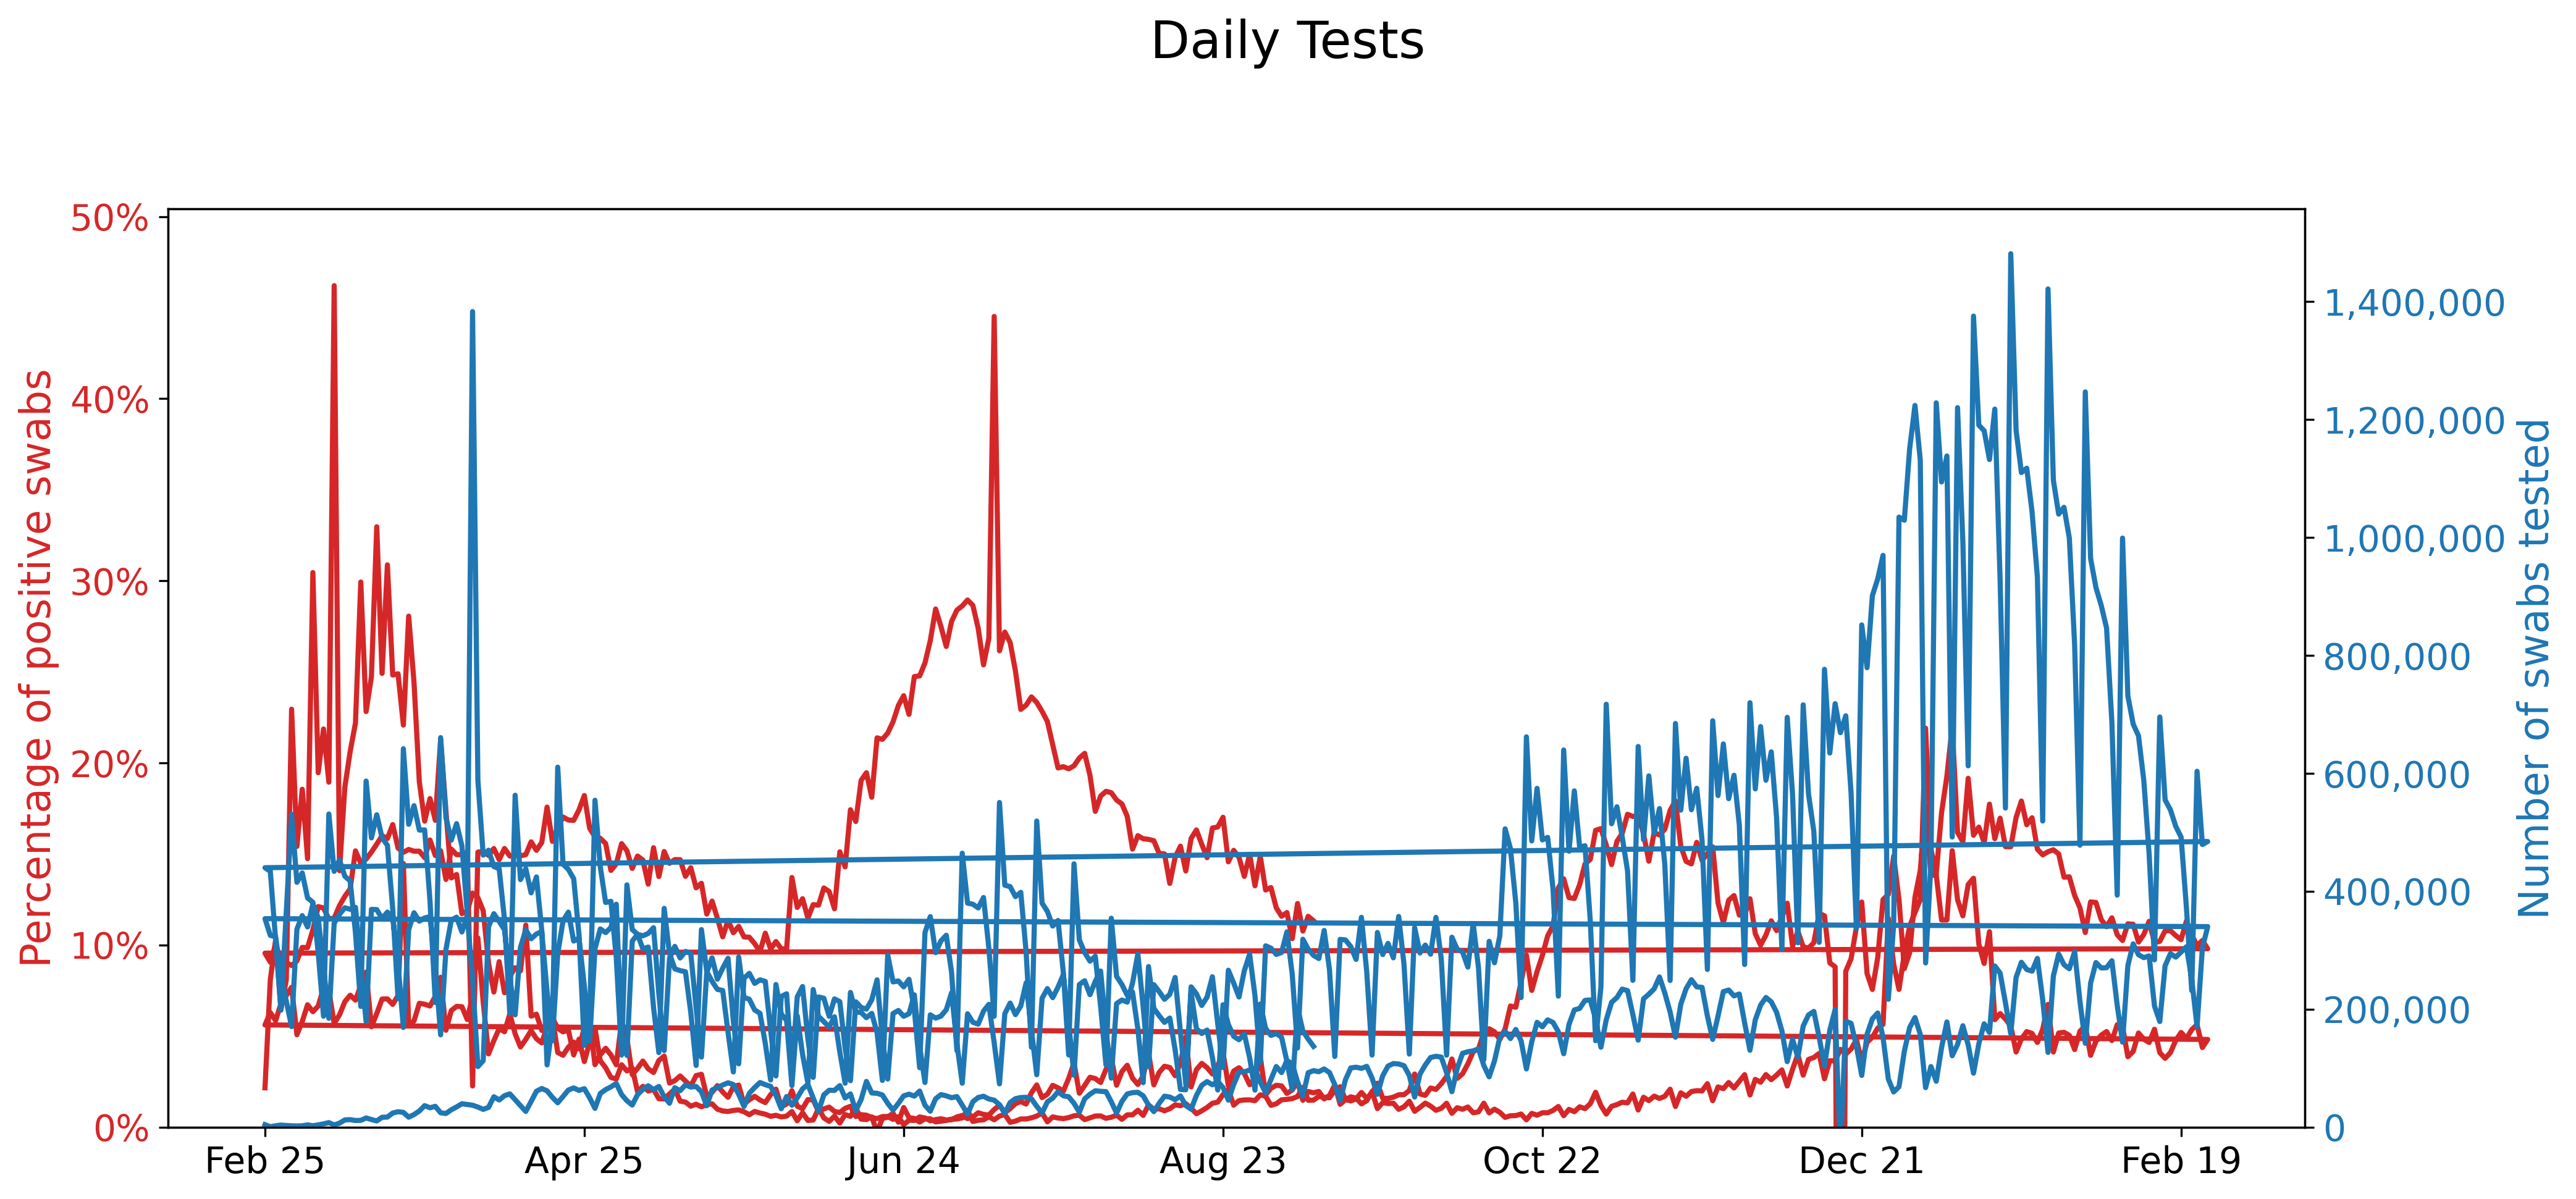

In [7]:
import matplotlib.ticker as mtick

def to_date_labels(arr):
    return list(map(lambda d: d.date().strftime('%b %d'), arr))


dataset = pd.read_json(DATA_SOURCE, convert_dates=['data'])

dataset['date'] = to_date_labels(dataset['data'])
dataset['new_swabs'] = dataset['tamponi'].diff()
dataset['new_cases'] = dataset['totale_casi'].diff()
dataset['new_cases_percentage'] = dataset['new_cases'] / dataset['new_swabs'] * 100
dataset = dataset[['date','new_cases_percentage','new_swabs']]
dataset.dropna(inplace=True)

fig, ax1 = plt.subplots(figsize=(14,6), dpi=300)
# plt.xticks(fontsize=12)


color = 'tab:red'
ax1.set_ylabel('Percentage of positive swabs', color=color, fontsize=16)
ax1.plot(dataset['date'], dataset['new_cases_percentage'], color=color, linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.tick_params(axis="x", labelsize=14)
ax1.tick_params(axis="y", labelsize=14)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Number of swabs tested', color=color, fontsize=16)
ax2.plot(dataset['date'], dataset['new_swabs'], color=color, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.tick_params(axis="y", labelsize=14)

ax1.xaxis.set_major_locator(plt.MaxNLocator(8))
fig.suptitle('Daily Tests', y=1.07, fontsize=20)
ax1.set_ylim(ymin=0)
ax2.set_ylim(ymin=0)
fig.tight_layout()

plt.savefig('daily_tests.png', dpi=fig.dpi, bbox_inches='tight', pad_inches=0.2)
plt.show()